In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import Subset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
import numpy as np
import torch.nn as nn
import torch
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
dataset = MNIST(root='data', transform=transform, train=True, download=False)
subset_data = Subset(dataset, np.arange(30000))
public_data = Subset(dataset, np.arange(30000, 60000))

In [4]:
indices = []
dist = [50, 3000, 55, 100, 3100, 40, 200, 100, 50, 3100]

for i, n in enumerate(dist):
    n_indices = np.where(dataset.targets == i)[0]
    indices.extend(n_indices[:n])

dataset = Subset(dataset, indices)

In [5]:
dataloader = DataLoader(dataset, batch_size=32)

In [6]:
class Mnist_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 2)
        )
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
    
    def encode(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

    def decode(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [7]:
model = Mnist_Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

epochs = 30

for epoch in range(epochs):
    model.train()
    train_loss = []

    for x, _ in dataloader:
        output = model(x)
        loss = loss_fn(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    
    train_loss = np.mean(train_loss)

    print('Epoch {}/{} \t train loss {}'.format(epoch + 1, epochs, train_loss), end="\r")

In [15]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
out_data = []

model.eval()
with torch.no_grad():
    for x, y in dataloader:
        encoded = model.encode(x)
        enc_x = encoded.detach().numpy()[:, 0][0]
        enc_y = encoded.detach().numpy()[:, 1][0]
        output = model(x)
        loss = torch.mean((output[0]-x[0])*(output[0]-x[0]))
        y = str(y.item()) if y.item() in [1, 4, 9] else 'Rest'
        out_data.append([enc_x, enc_y, y, loss.item()])

df_local = pd.DataFrame(out_data, columns=['h_x', 'h_y', 'y_true', 'loss'])

In [16]:
public_loader = DataLoader(public_data, batch_size=1, shuffle=False)
out_data = []

model.eval()
with torch.no_grad():
    for x, y in public_loader:
        encoded = model.encode(x)
        enc_x = encoded.detach().numpy()[:, 0][0]
        enc_y = encoded.detach().numpy()[:, 1][0]
        output = model(x)
        loss = torch.mean((output[0]-x[0])*(output[0]-x[0]))
        y = str(y.item()) if y.item() in [1, 4, 9] else 'Rest'
        out_data.append([enc_x, enc_y, y, loss.item()])

df_public = pd.DataFrame(out_data, columns=['h_x', 'h_y', 'y_true', 'loss'])

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc, cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('text', usetex=True)
sns.set_theme()
sns.set(font_scale=2.5, style="whitegrid")

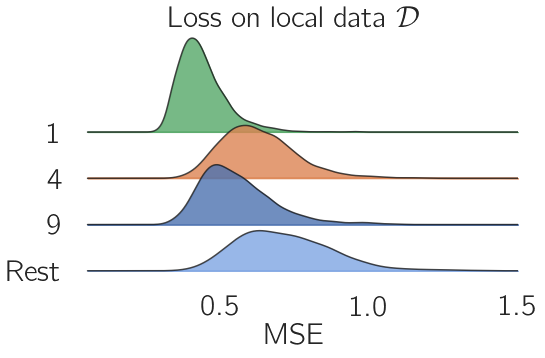

In [21]:
cmap = [(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
                (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
                (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                (0.4980392156862745, 0.6470588235294118, 0.8901960784313725)]
palette_cmap = ListedColormap(cmap)

from joypy import joyplot

df = pd.DataFrame(out_data, columns=['h_x', 'h_y', 'y_true', 'loss'])

fig, ax = joyplot(data=df_local[['loss', 'y_true']], by='y_true', figsize=(8, 5), overlap=0.5, colormap=palette_cmap, alpha=0.8,)

for a in ax:
    a.set_xlim([0, 1.5])

plt.xlabel('MSE')

#plt.tight_layout()
#plt.subplots_adjust(bottom=0.35)
plt.title(r'Loss on local data $\mathcal{D}$')
plt.savefig('../thesis_images/ae_example_local_loss.png', dpi=300)
plt.show()

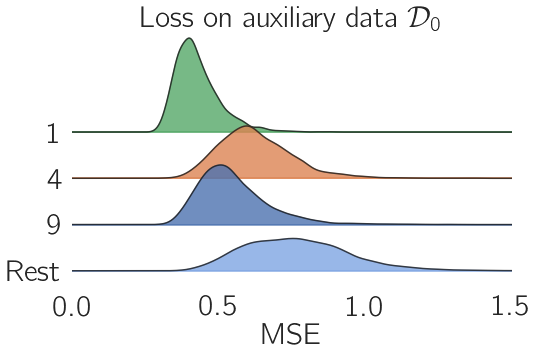

In [23]:
cmap = [(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
                (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
                (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
                (0.4980392156862745, 0.6470588235294118, 0.8901960784313725)]
palette_cmap = ListedColormap(cmap)

from joypy import joyplot

df = pd.DataFrame(out_data, columns=['h_x', 'h_y', 'y_true', 'loss'])

fig, ax = joyplot(data=df_public[['loss', 'y_true']], by='y_true', figsize=(8, 5), overlap=0.5, colormap=palette_cmap, alpha=0.8,)

for a in ax:
    a.set_xlim([0, 1.5])

plt.xlabel('MSE')

#plt.tight_layout()
#plt.subplots_adjust(bottom=0.35)
plt.title(r'Loss on auxiliary data $\mathcal{D}_0$')
plt.savefig('../thesis_images/ae_example_public_loss.png', dpi=300)
plt.show()

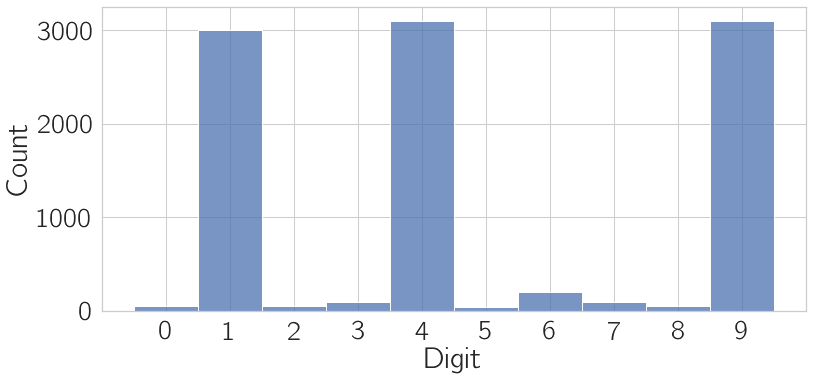

In [138]:
digits = []

for i, n in enumerate(dist):
    digits.extend([i] * n)

fig, ax = plt.subplots(1, figsize=(12, 6))
sns.histplot(ax=ax, data=digits, discrete=True)
ax.set_xlabel('Digit')
ax.set_xticks(np.arange(10))
plt.tight_layout()
plt.savefig('../thesis_images/ae_example_dist.png', dpi=300)
plt.show()

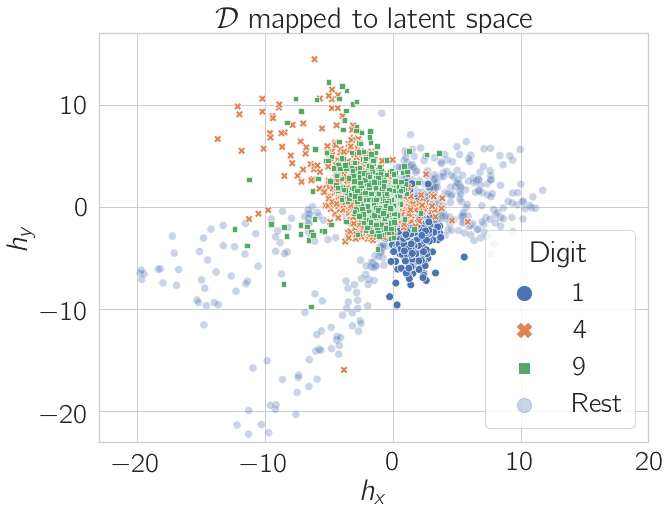

In [51]:
fig, ax = plt.subplots(1, figsize=(10, 10))

sns.scatterplot(ax=ax, data=df_local[df_local.y_true == 'Rest'], x='h_x', y='h_y', alpha=0.3, hue='y_true', s=60)
sns.scatterplot(ax=ax, data=df_local[df_local.y_true != 'Rest'], x='h_x', y='h_y', hue='y_true', style='y_true', s=60, hue_order=['1', '4', '9'])


handles, labels = ax.get_legend_handles_labels()
for h in handles:
    h.set_sizes([200])
handles[0].set_alpha(0.3)
ax.get_legend().remove()

handles.append(handles[0])
del handles[0]
labels.append(labels[0])
del labels[0]

ax.legend(loc='lower right', handles=handles, labels=labels, title='Digit')

ax.set_xlabel(r'$h_x$')
ax.set_ylabel(r'$h_y$')
ax.set_xlim([-23, 20])
ax.set_ylim([-23, 17])
plt.title(r'$\mathcal{D}$ mapped to latent space')
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)
plt.savefig('../thesis_images/ae_example_local_latent_space.png', dpi=300)
plt.show()

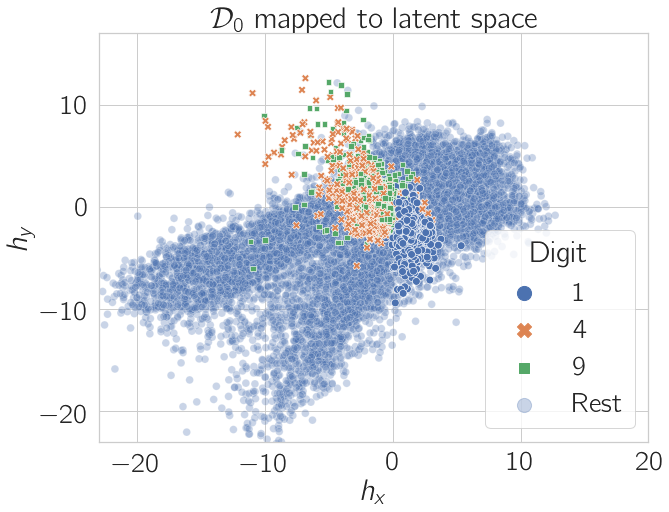

In [52]:
fig, ax = plt.subplots(1, figsize=(10, 10))

sns.scatterplot(ax=ax, data=df_public[df_public.y_true == 'Rest'], x='h_x', y='h_y', alpha=0.3, hue='y_true', s=60)
sns.scatterplot(ax=ax, data=df_public[df_public.y_true != 'Rest'], x='h_x', y='h_y', hue='y_true', style='y_true', s=60, hue_order=['1', '4', '9'], style_order=['1', '4', '9'])


handles, labels = ax.get_legend_handles_labels()
for h in handles:
    h.set_sizes([200])
handles[0].set_alpha(0.3)
ax.get_legend().remove()

handles.append(handles[0])
del handles[0]
labels.append(labels[0])
del labels[0]

ax.legend(loc='lower right', handles=handles, labels=labels, title='Digit')

ax.set_xlabel(r'$h_x$')
ax.set_ylabel(r'$h_y$')
ax.set_xlim([-23, 20])
ax.set_ylim([-23, 17])
plt.title(r'$\mathcal{D}_0$ mapped to latent space')
plt.tight_layout()
plt.subplots_adjust(bottom=0.35)
plt.savefig('../thesis_images/ae_example_public_latent_space.png', dpi=300)
plt.show()